In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


In [4]:
# load the data
data = pd.read_csv('merged_marginal_data.csv')

In [5]:
# Load the data
data = pd.read_csv('merged_marginal_data.csv')

# Experiment with a longer sequence length (e.g., 336 hours for 2 weeks)
sequence_length = 336  # 2 weeks

# Prepare the input features (using Hour_Sin and Hour_Cos) and the target price
X, y = [], []

for i in range(len(data) - sequence_length):
    features = data.iloc[i:i+sequence_length][['Price1', 'Hour_Sin', 'Hour_Cos']].values.flatten()
    X.append(features)
    y.append(data.iloc[i + sequence_length]['Price1'])

X = np.array(X)
y = np.array(y)

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert to torch tensors
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


In [6]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [7]:
# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = x.view(-1, sequence_length, 3)  # Reshape input for LSTM (batch_size, sequence_length, feature_dim)
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Only take the output of the last time step
        return out


In [8]:
# Initialize both models
input_size = X_train.shape[1]  # Flattened input size for MLP
mlp_model = MLP(input_size)
lstm_model = LSTM(input_size=3, hidden_size=4, num_layers=2)  # LSTM input size is feature_dim (3)

# Define loss and optimizer for both models
criterion = nn.MSELoss()
mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)


In [9]:
# Training function
def train_model(model, optimizer, epochs=100):
    best_val_loss = float('inf')
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_output = model(X_val)
            val_loss = criterion(val_output, y_val)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")
    
    return model


In [10]:
print("Training MLP model...")
trained_mlp = train_model(mlp_model, mlp_optimizer)


Training MLP model...
Epoch [10/100], Loss: 8041.3208, Val Loss: 7667.2412
Epoch [20/100], Loss: 4729.5015, Val Loss: 4233.8774
Epoch [30/100], Loss: 1659.8915, Val Loss: 1568.3806
Epoch [40/100], Loss: 1964.9137, Val Loss: 1895.3228
Epoch [50/100], Loss: 1560.2531, Val Loss: 1533.4622
Epoch [60/100], Loss: 1576.6177, Val Loss: 1525.7716
Epoch [70/100], Loss: 1524.0610, Val Loss: 1501.2664
Epoch [80/100], Loss: 1511.1072, Val Loss: 1482.4552
Epoch [90/100], Loss: 1504.2544, Val Loss: 1473.0195
Epoch [100/100], Loss: 1496.4355, Val Loss: 1469.3582


In [11]:
print("Training LSTM model...")
trained_lstm = train_model(lstm_model, lstm_optimizer)


Training LSTM model...
Epoch [10/100], Loss: 9344.2100, Val Loss: 9200.2998
Epoch [20/100], Loss: 9334.0078, Val Loss: 9190.0869
Epoch [30/100], Loss: 9322.8877, Val Loss: 9178.9209
Epoch [40/100], Loss: 9310.3750, Val Loss: 9166.3125
Epoch [50/100], Loss: 9295.7871, Val Loss: 9151.5596
Epoch [60/100], Loss: 9278.2148, Val Loss: 9133.7402
Epoch [70/100], Loss: 9256.6133, Val Loss: 9111.8164
Epoch [80/100], Loss: 9230.1631, Val Loss: 9085.0361
Epoch [90/100], Loss: 9199.0332, Val Loss: 9053.7227
Epoch [100/100], Loss: 9165.2197, Val Loss: 9020.0557


In [12]:
# Evaluation function
def evaluate_model(model, X, y, model_name=""):
    model.eval()
    with torch.no_grad():
        predictions = model(X).numpy()
        true_values = y.numpy()
        test_loss = criterion(torch.tensor(predictions), torch.tensor(true_values))
        print(f"{model_name} Test Loss: {test_loss.item():.4f}")
        return predictions, true_values


MLP Test Loss: 1505.9290
LSTM Test Loss: 9388.2344


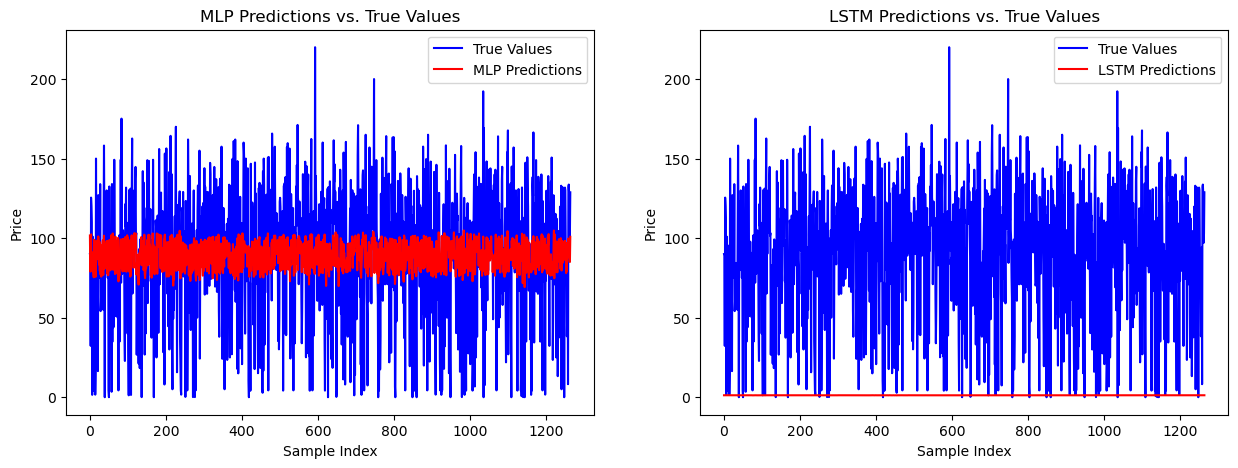

In [13]:
# Evaluate both models on the test set
mlp_predictions, mlp_true_values = evaluate_model(trained_mlp, X_test, y_test, "MLP")
lstm_predictions, lstm_true_values = evaluate_model(trained_lstm, X_test, y_test, "LSTM")

# Plot predictions vs. true values for both models
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(mlp_true_values, label="True Values", color='blue')
plt.plot(mlp_predictions, label="MLP Predictions", color='red')
plt.legend()
plt.title("MLP Predictions vs. True Values")
plt.xlabel("Sample Index")
plt.ylabel("Price")

plt.subplot(1, 2, 2)
plt.plot(lstm_true_values, label="True Values", color='blue')
plt.plot(lstm_predictions, label="LSTM Predictions", color='red')
plt.legend()
plt.title("LSTM Predictions vs. True Values")
plt.xlabel("Sample Index")
plt.ylabel("Price")

plt.show()
